<body>
<h1 style='text-align:center'>Identifying suitable locations for new supermarket investments<br>in the Regional Unit of Thessaloniki area, Greece.</h1>

<h3 style='text-align:center'> IBM's Applied Data Science Capstone on Coursera - Final Project</h3>
<h4 style='text-align:center'>by Joseph Doundoulakis</h4>

<center>
    <h5 style='text-align:center'>M.Eng. Spatial Planning and Development 
    <br>
    Aristotle University of Thessaloniki, Faculty of Engineering</h5>
    <h6 style='color:rgb(100,100,100)'>Contact: iosif.doundoulakis@outlook.com</h6>
</center>
</body>

__Disclaimer:__ _This project is developed within the scope of IBM's Applied Data Science Capstone course on Coursera, for the purpose of getting accustomed to Data Science technologies and methodologies and acquiring the IBM's Data Science certification. The given scenario is hypothetical and its solution presumptuous, purely for skill demonstration purposes._

## Introduction / Business Problem:

A local supermarket chain called "Masoutis" is dominating competition in the Regional Unit of Thessaloniki.
"AB Vasilopoulos" owned by the Dutch company "Ahold Delhaize", already present in the region, wants to increase investment in the area and get a better hold of the market.

## Data

1. The **area boundaries** will be needed. The shapefile for the Regional Unit divisions of Greece are provided by the **Hellenic Statistical Authority** [here](https://www.statistics.gr/documents/20181/1194366/perif_enot.rar/1d3746c9-88df-4cfb-87fb-d8199f1f345b). For this project they have already been downloaded and the Regional Unit of Thessaloniki extracted separately.
<p></p>
1. For the completion of this assignment, the main task would be to identify and analyse the competition in the area, using the insights gained in order to make an informed decision about the best possible locations for a new investment. The **Foursquare API** will be used to extract the venues of interest (**Supermarkets, grocery stores**) for the entire Regional Unit of Thessaloniki.
<p></p>
1. Since the actual area of interest is rather large (**3,683 km²**), a call method must be devised in order to ensure the efficient use of the API while achieving an as thorough as possible search in the entire region. The area's **road network** on OpenStreetMap will be used as a **guide for the call locations** with the Foursquare API. Since venues and particularly supermarkets and grocery stores require access by road, using the OpenStreetMap road vectors to generate call locations makes more sense than searching the entire region using a grid (e.g. including agricultural fields and bare mountains).Additionally, the OpenStreetMap road network vectors are organized in categories, which will help identify the residential areas of the region.
<p></p>
1. Supermarkets are meant to serve and profit from residents and be close to towns in general, hence, the locations of towns and villages in the area will be necessary, as well as the population of each town to estimate demand. The town location shapefiles as well as census data are provided by the **Hellenic Statistical Authority**. [Town locations](https://www.statistics.gr/documents/20181/1194366/oikismoi_2011.rar/05cc0b6c-5b70-418b-b9fd-33cfe72f5d19), [Census data](https://www.statistics.gr/documents/20181/1210503/resident_population_census2011rev.xls/956f8949-513b-45b3-8c02-74f5e8ff0230).

## Methodology

1. The road network shapefiles will be used to create call locations for the Foursquare API.
2. The extracted venue dataset will be cleaned and organized by supermarket brand.
3. The average position of each supermarket brand will be evaluated, based on local demand and competition. The evaluation of the AB Vasilopoulos brand will be used as a point of reference, in order to look for locations that could potentially improve its overall position.
5. A search grid will be generated within the study area and each point will be evaluated as well, according to demand and competition.
6. Finally, the point-grid will be filtered down to points that improve the average position of the AB Vasilopoulos brand and the final map will be produced.

<center><h1>__________________</h1></center><br>
<center><h2>Part A: Data Acquisition & Preparation</h2></center>

### A.1. Import packages:

In [257]:
import pandas as pd, geopandas as gpd
import numpy as np
import requests, os, re, time
import json
import geocoder
import fiona
import matplotlib.pyplot as plt, matplotlib.patches as mpatches
import overpy

pd.options.display.max_rows=100

### A.2. Set API parameters
*Client id, secret, version, limit, radius)*

In [258]:
params = dict(client_id = 'client_id',
              client_secret = 'client_secret',
              v = '20200605',
              limit = 2000,
              radius = 100000)

### A.3. Set the region of interest.
Downloaded and clipped from the Hellenic Statistical Authority (www.statistics.gr)

In [259]:
# Source statistics.gr
nomos = gpd.read_file('THESSALONIKI\\Nomos_Thessalonikis.shp')
xmin, ymin, xmax, ymax = nomos.to_crs(4326).total_bounds


### A.4. Download the road network vectors for the region using the OpenStreetMap API.
Load on a GeoDataFrame.

In [260]:
from shapely.geometry import LineString
osm = overpy.Overpass()

def fetch_roads():
    
    if not os.path.exists(".\THESSALONIKI\PE_Roads\PE_Roads.shp"):

        osm_result = osm.query("""
                               (area[name="Περιφερειακή Ενότητα Θεσσαλονίκης"];)->.a;
                               way["highway"](area.a);
                               (._;>;);
                               out;
                               """)
        
        gdf = gpd.GeoDataFrame([way.tags['highway'] for way in osm_result.ways], columns=['class'],
                                geometry=[LineString([(node.lon, node.lat) for node in way.nodes])
                                          for way in osm_result.ways],
                              crs="EPSG:4326")
        
        gdf = gpd.clip(gdf, nomos.to_crs(4326))
        
        if not os.path.exists(".\THESSALONIKI\PE_Roads"): os.makedirs(".\THESSALONIKI\PE_Roads", exist_ok=True)

        gdf.to_file(".\THESSALONIKI\PE_Roads\PE_Roads.shp")

    else:
        
        gdf = gpd.read_file(".\THESSALONIKI\PE_Roads\PE_Roads.shp")
        
    return gdf


road_network = fetch_roads()
road_network

,class,geometry
0,unclassified,"LINESTRING (22.87761 40.70189, 22.87760 40.701..."
1,residential,"LINESTRING (22.85399 40.68832, 22.85413 40.688..."
2,residential,"LINESTRING (22.84687 40.68579, 22.84676 40.686..."
3,residential,"LINESTRING (22.84761 40.68597, 22.84750 40.686..."
4,residential,"LINESTRING (22.84838 40.68612, 22.84829 40.686..."
...,...,...
46949,residential,"LINESTRING (22.94859 40.66288, 22.94862 40.66253)"
46950,residential,"LINESTRING (22.94242 40.66200, 22.94232 40.661..."
46951,residential,"LINESTRING (22.93825 40.66737, 22.93816 40.667..."
46952,residential,"LINESTRING (22.93156 40.67175, 22.93156 40.671..."


### A.5. Download town locations, census data and join on a GeoDataFrame.

Together with the DataFrame, a distance tolerance is computed in the 'buffer' column, which indicates the location's distance from the town epicenter the supermarket company is willing to tolerate, depending on the town's population. It is assumed to be given by the formula `6*sqrt(population) + 700` in meters, provided by the company.

In [261]:
def fetch_towns_and_population():
    
    
    !if not exist .\oikismoi_2011.rar wget https://www.statistics.gr/documents/20181/1194366/oikismoi_2011.rar
    !if not exist .\oikismoi_2011\ΟΙΚΙΣΜΟΙ_2011.shp ("C:\Program Files\WinRAR\unrar" x oikismoi_2011.rar) else echo file exists
    
    gdf = gpd.read_file(".\oikismoi_2011\ΟΙΚΙΣΜΟΙ_2011.shp", encoding='ISO-8859-7')
    gdf = gpd.clip(gdf, nomos)
    
    pop = pd.read_excel("https://www.statistics.gr/documents/20181/1210503/"+\
                    "resident_population_census2011rev.xls/956f8949-513b-45b3-8c02-74f5e8ff0230", header=1)
    pop.columns = [column.strip() for column in pop.columns]
    pop = pop[['Γεωγραφικός κωδικός Καλλικράτη', 'Μόνιμος Πληθυσμός']].set_index('Γεωγραφικός κωδικός Καλλικράτη')
    
    gdf = gdf.join(pop, how='left', on='KALCODE').reset_index(drop=True)
    
    # Calculate and apply a buffer distance for each center, based on population
    gdf['buffer'] = np.sqrt(gdf['Μόνιμος Πληθυσμός'])*6 + 800
    gdf["geometry"] = gdf.apply(lambda x: x.geometry.buffer(x.buffer), axis=1)
    gdf = gpd.clip(gdf, nomos)
    
    print("\nPopulation stats:", gdf['Μόνιμος Πληθυσμός'].describe(),
          "\nTown buffer stats in meters:", gdf['buffer'].describe(), sep='\n')
    
    return gdf
    
    
towns = fetch_towns_and_population()

pd.options.display.max_rows = 100
towns

file exists

Population stats:
count       178.000000
mean       6239.050562
std       25893.326234
min           1.000000
25%         272.000000
50%         759.000000
75%        3094.000000
max      315196.000000
Name: Μόνιμος Πληθυσμός, dtype: float64

Town buffer stats in meters:
count     178.000000
mean     1092.273893
std       374.123148
min       806.000000
25%       898.952543
50%       965.295388
75%      1133.742416
max      4168.539149
Name: buffer, dtype: float64


,OBJECTID,LAT,LON,KALCODE,OIKISMOS,TOP_KOIN,geometry,Μόνιμος Πληθυσμός,buffer
0,6365,40.411618,23.006545,0705020201,"Μεσημέριον,το",Τοπική Κοινότητα Μεσημερίου,"POLYGON ((416766.454 4473918.145, 416761.366 4...",1831,1056.741115
1,6375,40.425627,23.028553,0706030301,"Κάτω Σχολάριον,το",Τοπική Κοινότητα Κάτω Σχολαρίου,"POLYGON ((418659.295 4475452.394, 418654.166 4...",1954,1065.224433
2,6377,40.424432,22.926316,0705020101,"Επανομή,η",Δημοτική Κοινότητα Επανομής,"POLYGON ((410288.297 4475420.199, 410281.707 4...",8979,1368.545513
3,6384,40.434700,23.091168,0706020301,"ʼγιος Αντώνιος,ο",Τοπική Κοινότητα Αγίου Αντωνίου,"POLYGON ((423868.603 4476403.023, 423864.016 4...",647,952.617168
4,6407,40.462015,22.858650,0705030101,"Νέα Μηχανιώνα,η",Δημοτική Κοινότητα Νέας Μηχανιώνας,"POLYGON ((404595.504 4479663.952, 404588.945 4...",8775,1362.049820
...,...,...,...,...,...,...,...,...,...
173,0,40.703796,22.930426,0714010102,"ʼγιος Γεώργιος,ο",Δημοτική Κοινότητα Ωραιοκάστρου,"POLYGON ((410553.758 4506426.446, 410549.381 4...",329,908.830143
174,0,40.705623,22.935402,0714010104,"Νεόκαστρο,το",Δημοτική Κοινότητα Ωραιοκάστρου,"POLYGON ((410992.471 4506624.225, 410988.019 4...",432,924.707658
175,0,40.690489,22.913367,0714010103,"Εγνατία,η",Δημοτική Κοινότητα Ωραιοκάστρου,"POLYGON ((409046.354 4504966.980, 409042.209 4...",103,860.893349
176,0,40.662336,22.854686,0704010202,"Αγία Σοφία,η",Δημοτική Κοινότητα Διαβατών,"POLYGON ((404198.579 4501904.828, 404193.705 4...",1250,1012.132034


### A.6. Visualize all the ancillary data.

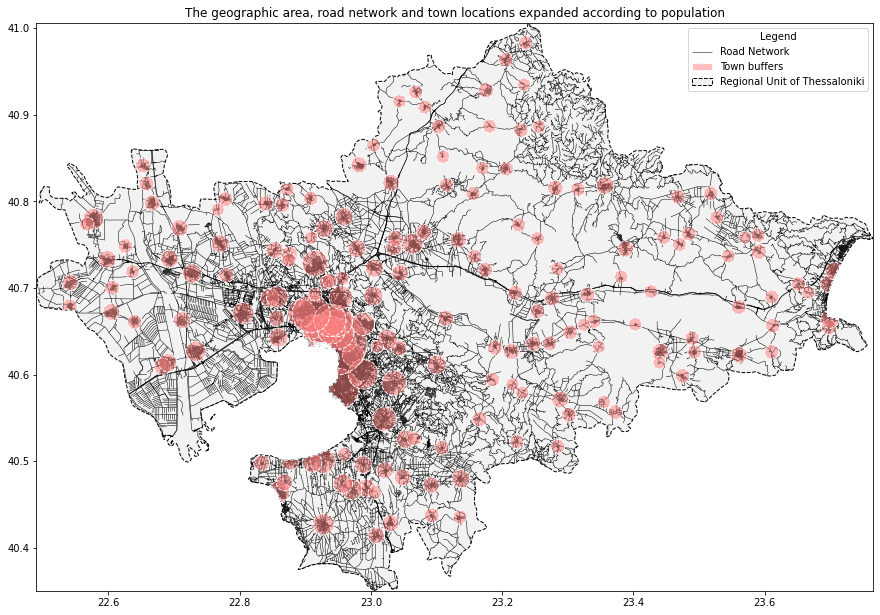

In [262]:
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1, 1)
xmin, ymin, xmax, ymax = nomos.to_crs(4326).total_bounds
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)

nomos.to_crs(4326).plot(ax=ax, color=(.9, .9, .9, .5), edgecolor=(.0,.0,.0), ls='--')
road_network.plot(ax=ax, label='Road Network', lw=.5, color='k')
towns.to_crs(4326).plot(ax=ax, label='Towns', zorder=2, markersize=.5,
                        color=(1.,.5,.5,.5), ec='white', ls='--')

ax.set_title("The geographic area, road network and town locations expanded according to population")

handles = [mpatches.Patch(facecolor=(1.,.5,.5,.5), ec='white', ls='--', label='Town buffers'),
           mpatches.Patch(facecolor=(.9,.9,.9,.5), edgecolor=(0,0,0), ls='--', label='Regional Unit of Thessaloniki')]
legend = ax.legend(handles=[*ax.get_legend_handles_labels()[0], *handles], title='Legend')

### A.7. Create call locations for the Foursquare API:
The entire road network will be used to generate call-points in 500 meter intervals along each road segment.

,geometry,WGS84_coords,Call_flag
0,POINT (405029.703 4505984.461),"(40.70188998236258, 22.877605188251756)",False
1,POINT (403262.735 4504514.599),"(40.68844592756529, 22.856919788297475)",False
2,POINT (402353.688 4504560.125),"(40.68874896583547, 22.846156538582953)",False
3,POINT (402409.013 4504635.360),"(40.68943314328464, 22.846799485665656)",False
4,POINT (402584.752 4504325.899),"(40.686666624115865, 22.848926893463904)",False
...,...,...,...
27935,POINT (402525.395 4481085.940),"(40.47733703991266, 22.85180961377131)",False
27936,POINT (402499.954 4481163.581),"(40.47803338329694, 22.851497612561577)",False
27937,POINT (403408.164 4481006.767),"(40.476726881556054, 22.862234137883835)",False
27938,POINT (403464.617 4480994.891),"(40.47662647006833, 22.862901815475396)",False


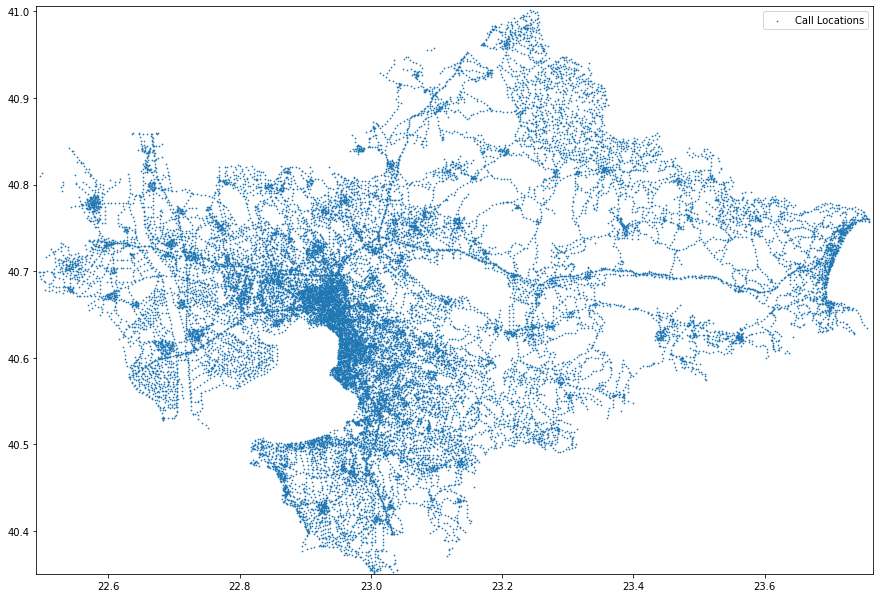

In [263]:
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1, 1)
xmin, ymin, xmax, ymax = nomos.to_crs(4326).total_bounds
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)

from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import unary_union


def make_points_aline(distance=400):
    
    """Create one point every 1000 meters of road length,
       to be used as a call location in the FourSquare API"""
    
    line = road_network.to_crs(2100).unary_union
    intervals = np.arange(0, line.length, distance)
    points = gpd.GeoDataFrame(geometry=[line.interpolate(interval) for interval in intervals],
                              crs="EPSG:2100")    
    points['WGS84_coords'] = points.geometry.to_crs(epsg=4326).apply(lambda x: (x.coords[0][1], x.coords[0][0]))
    points['Call_flag'] = False
    points.reset_index(drop=True, inplace=True)
    points.to_crs(4326).plot(ax=ax, markersize=.5, label='Call Locations', legend=True)
    ax.legend()
    
    return points
    
    
call_points = make_points_aline(500)    
call_points

### A.8. Make the API calls using the generated locations and store on disk:

In [264]:
def search_call(x, params=params):
    
    """
    Use the points generated as call locations for the Foursquare API and store on disk.
    
    """
    
    if x.Call_flag:
        
        return True
     
    params['ll'] = f'{x.WGS84_coords[0]},{x.WGS84_coords[1]}'
    url = 'https://api.foursquare.com/v2/venues/search'
    r = requests.get(url, params=params)
    
    remaining_calls = r.headers['X-RateLimit-Remaining']
    
    print(f'\nRemaining Calls: {remaining_calls}')
    
    while not int(remaining_calls):
        
        print(f'Hourly calls exhausted at {time.ctime()}', 'Trying again in 20 minutes.')
        time.sleep(1200)
        r = requests.get(url, params=params)
        remaining_calls = r.headers['X-RateLimit-Remaining']
    
    venue_list = r.json()['response']['venues']

    print(f"{x.name} # of {call_points.shape[0]} Locations: {len(venue_list)} Venues")
    
    with open(f"THESSALONIKI\_NOMOS_Venues\\{x.name}.json", "w") as file:
        
        json.dump(venue_list, file)

    return True


# for i, x in call_points[~call_points['Call_flag']].iterrows():  # ETA 5.5 hours
    
#     call_points.loc[i, 'Call_flag'] = search_call(x)


### A.9. Compile the json files into a (Geo)DataFrame and store on disk:

In [265]:
def load_venues(directory):    
    
    venues = []

    for file in os.listdir(directory):
        
        if file.endswith('.json'):
            
            with open(os.path.join(directory, file), 'r') as json_file:

                venue_list = json.load(json_file)

                for venue in venue_list:

                    venues.append(
                        (
                        venue['id'],
                        venue['name'],
                        venue['categories'][0]['name'] if (venue['categories'] and
                                                           venue['categories'][0]['name'] != 'Building') else 'Unknown',
                        venue['location']['lat'],
                        venue['location']['lng'],
                        ', '.join(venue['location']['formattedAddress']),
                        Point(venue['location']['lng'], venue['location']['lat'])
                        )
                    )
                
    gdf = gpd.GeoDataFrame(venues, columns=['id', 'name',
                                            'category',
                                            'lat', 'lng',
                                            'address', 'geometry'],
                           geometry='geometry', crs='EPSG:4326')
        
    gdf = gdf.groupby('id').first().reset_index()
    gdf = gpd.clip(gdf, nomos.to_crs(4326))
    gdf.crs="EPSG:4326"
    
    print('Done.')
    
    return gdf


if os.path.exists("THESSALONIKI\_NOMOS_Venues\\venue_data.shp"):
    
    venue_data = gpd.read_file("THESSALONIKI\_NOMOS_Venues\\venue_data.shp")

else:
    venue_data = load_venues('THESSALONIKI\_NOMOS_Venues')
    venue_data.to_file("THESSALONIKI\_NOMOS_Venues\\venue_data.shp", encoding='utf-8')
    venue_data.drop(columns='geometry').to_csv("THESSALONIKI\_NOMOS_Venues\\venue_data.csv", header=1, encoding='utf-8')

### A.10. Visualize and explore the venue dataset:

Supermarket stores would appear to be under the categories "Supermarket" or "Grocery Store". Other categories will also be checked for known supermarket brands, to identify possible discrepancies in the dataset.

Known Supermarket brands in other categories: 
                                            name                 category
2932                              Γαλαξίας Λητής       Miscellaneous Shop
2951                    Αρβανιτίδης Super Market        Food & Drink Shop
3082              Γαλαξίας Δημοτικά Γήπεδα Τένις             Tennis Court
4166                         Μασούτης (Αποθήκες)         Storage Facility
4692                    Αρβανιτίδης Super Market         Department Store
6079                          Μασούτης (Γραφεία)                   Office
11338                                Μασούτης HQ                   Office
11920  ΑΒ ΒΑΣΙΛΟΠΟΥΛΟΣ ΚΕΝΤΡΙΚΕΣ ΑΠΟΘΗΚΕΣ ΣΙΝΔΟΥ                  Factory
14124                                       Lidl           Discount Store
14133                                    Lidl HQ                   Office
19670               Lidl Logistics Center Sindos      Distribution Center
21848                                   Μασούτης  Fruit & Vegetab

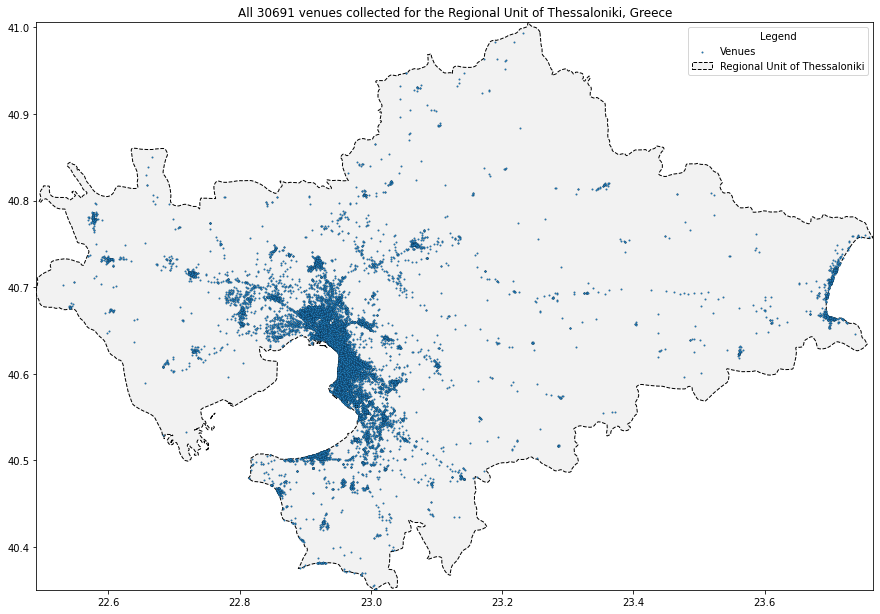

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

nomos.to_crs(4326).plot(ax=ax, color=(.9,.9,.9,.5), edgecolor=(.0,.0,.0), ls='--')
venue_data.plot(ax=ax, markersize=3., label='Venues', edgecolor=(.0,.0,.0), lw=.1)

xmin, ymin, xmax, ymax = nomos.to_crs(4326).total_bounds

ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_title(f"All {venue_data.shape[0]} venues collected for the Regional Unit of Thessaloniki, Greece")

handles = [mpatches.Patch(facecolor=(.9,.9,.9,.5), edgecolor=(0,0,0), ls='--', label='Regional Unit of Thessaloniki')]
ax.legend(handles=[*ax.get_legend_handles_labels()[0], *handles], title='Legend')

pd.options.display.max_rows=1000

# Check for category discrepancies in known Supermarket brands
print("Known Supermarket brands in other categories: ",
    venue_data.loc[(venue_data.name.str.lower().str.match("μασο[ύυ]της|masoutis| ?αβ | ?ab |σκλαβεν[ιί]της|lidl|"\
                                                            "αρβανιτ[ίι]δης|my ?market|γαλαξ[ίι]ας")) &
                     (~venue_data.category.isin(['Supermarket', 'Grocery Store'])), ['name', 'category']], sep='\n')

# Check Supermarket and Grocery Store names
print("\nSupermarkets and Grocery Stores: ",
    venue_data.loc[(venue_data.category == 'Supermarket') |
               (venue_data.category == 'Grocery Store'), 'name'].value_counts().sort_index(), sep='\n')

It appears that a few known supermarket brand's stores are classified in different categories. While they are not many and are not expected to influence the outcome significantly, their collection can be attempted after the stores under "Supermarket" and "Grocery Store" categories are properly cleaned and grouped.

### A.11. Cleansing the "Supermarket" and "Grocery Store" categories using regular expressions:
The main supermarket chains recognized are:
* Μασούτης
* Lidl
* AB Βασιλόπουλος
* Σκλαβενίτης
* Γαλαξίας
* MyMarket
* Αρβανιτίδης
* Discount Markt
* Ελληνικά Market
* Bazaar
* Αφροδίτη
* Άριστα

While the rest appear to be more isolated, less competitive brands with fewer stores.

Other              124
Μασούτης           123
AB Βασιλόπουλος     43
LIDL                30
Αρβανιτίδης         27
Σκλαβενίτης         22
Γαλαξίας            16
Discount Markt      15
Αφροδίτη            13
Bazaar              12
Ελληνικά Market     12
Άριστα              11
MyMarket             6
Name: name, dtype: int64

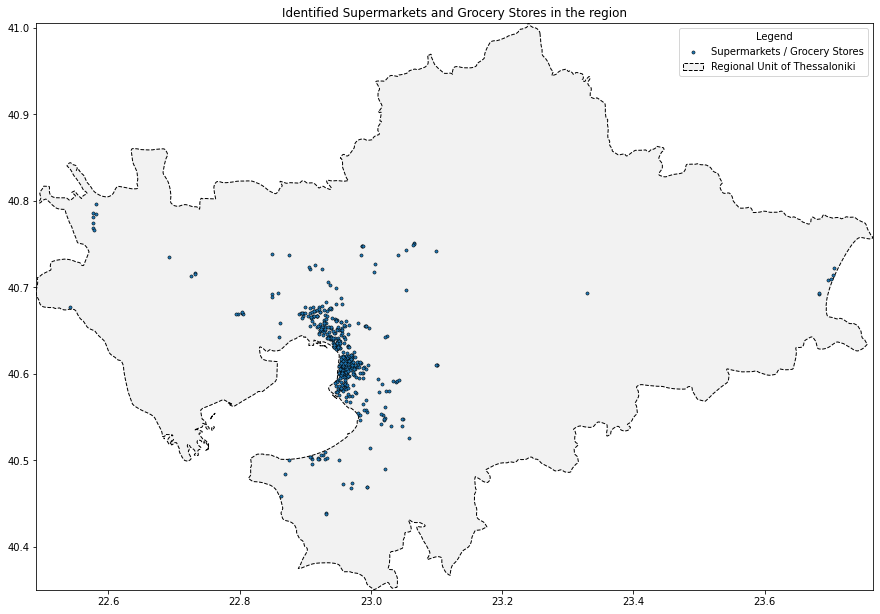

In [342]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

supermarkets = venue_data[(venue_data.category == 'Supermarket') |
                          (venue_data.category == 'Grocery Store')].copy()

# Include discrepancies identified above
supermarkets = supermarkets.append(venue_data.loc[(venue_data.name == 'Lidl') &
                                   (venue_data.category == 'Discount Store')])
supermarkets = supermarkets.append(venue_data.loc[(venue_data.name == 'Μασούτης') &
                                   (venue_data.category == 'Fruit & Vegetable Store')])
supermarkets = supermarkets.append(venue_data.loc[[2932, 2951, 4692]])

supermarkets.drop(columns=['category', 'address'], inplace=True)
supermarkets.reset_index(drop=True, inplace=True)

supermarkets.loc[supermarkets['name'].str.contains(' *[AaΑα][BbΒβ] +'), 'name'] = 'AB Βασιλόπουλος'
supermarkets.loc[supermarkets.name.str.contains(' ?[MmΜμ][AaΑαΆά][Σσ][Οο][ΥυΎύ]της *|Маршрутис|Mr.? Grand'),
                 'name'] = 'Μασούτης'
supermarkets.loc[supermarkets.name.str.contains('Lidl'), 'name'] = 'LIDL'
supermarkets.loc[supermarkets.name.str.contains('[Γγ]αλαξ[ίι]ας'), 'name'] = 'Γαλαξίας'
supermarkets.loc[supermarkets.name.str.contains('Αρβανιτ[ίι]δης|Arvanitidis'),
                 'name'] = 'Αρβανιτίδης'
supermarkets.loc[supermarkets.name.str.contains('[Mm]y ?[Mm]arket'), 'name'] = 'MyMarket'
supermarkets.loc[supermarkets.name.str.lower().str.contains('bazaar'), 'name'] = 'Bazaar'
supermarkets.loc[supermarkets.name.str.contains('[Dd]iscount [Mm]ar+ke?t'),
                 'name'] = 'Discount Markt'
supermarkets.loc[supermarkets.name.str.lower().str.contains('ελληνικ[αάοό] market|ελληνικ[αάοό] μ[άα]ρκετ'),
                 'name'] = 'Ελληνικά Market'
supermarkets.loc[supermarkets.name.str.contains('[Σσ]κλαβεν[ιί]της'), 'name'] = 'Σκλαβενίτης'
supermarkets.loc[supermarkets.name.str.lower().str.contains('αφροδ[ίι]τη'), 'name'] = 'Αφροδίτη'
supermarkets.loc[supermarkets.name.str.lower().str.contains('3b|3β'), 'name'] = '3B Markets'
supermarkets.loc[supermarkets.name.str.lower().str.contains('[αά]ριστα|arista'), 'name'] = 'Άριστα'

others = supermarkets.name.value_counts()[(supermarkets.name.value_counts() < 6)].index
supermarkets.loc[supermarkets.name.isin(others), 'name'] = 'Other'

nomos.to_crs(4326).plot(ax=ax, facecolor=(.9,.9,.9,.5), edgecolor=(.0,.0,.0), ls='--')
supermarkets.plot(ax=ax, edgecolor='black', label='Supermarkets / Grocery Stores',
                 markersize=10, lw=.5)

handles = [mpatches.Patch(facecolor=(.9,.9,.9,.5), edgecolor=(0,0,0), ls='--', label='Regional Unit of Thessaloniki')]
ax.legend(handles=[*ax.get_legend_handles_labels()[0], *handles], title='Legend')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title("Identified Supermarkets and Grocery Stores in the region")

supermarkets.name.value_counts()

Now, setting the location criteria straight, the company has requested that apart from the distance tolerance agreed in the beginning of this assignment, their investment should also be located at a maximum of **300 meters away from a residential street**. The road classification column in the OpenStreetMaps road dataset will be used to generate these areas and their intersection with the town buffers.

### A.12. Use the OpenStreetMap road network to form polygons up to 300 meters away from a residential street:

Towns with intersecting buffers will be considered as town clusters. The analysis will be done at the level of town clusters.

Generate their intersection with the town distance buffers. A shape union will be created for intersecting geometries in neighbour towns and their populations will be combined.

1) Towns Union:  (137, 3)
2) Buffered Residential Streets:  (18320,)
3) Residential buffers clipped to towns union:  (159, 1)
4) Residential buffers sjoined to towns:  (159, 6)


,geometry,town_cluster,cluster_population,area_sq_m,area_sum,population_ratio,cluster_store_count,polygon_store_count
0,"POLYGON ((416720.108 4473609.031, 416711.076 4...",1,1831,3327463.36,3327463.36,1831,0.0,0.0
1,"POLYGON ((408576.456 4474097.064, 408576.456 4...",3,8979,5217813.62,5217813.62,8979,2.0,2.0
2,"POLYGON ((417727.156 4474745.558, 417726.544 4...",4,1954,2384395.24,2384395.24,1954,0.0,0.0
3,"POLYGON ((426290.729 4475530.286, 426247.086 4...",0,227,1076970.39,1076970.39,227,0.0,0.0
4,"POLYGON ((423305.690 4475853.229, 423305.384 4...",5,647,1538441.15,1538441.15,647,0.0,0.0
5,"POLYGON ((403499.177 4478328.074, 403459.059 4...",13,10723,5903198.99,5903198.99,10723,2.0,2.0
6,"POLYGON ((412648.964 4478550.154, 412648.964 4...",2,16191,12400637.34,12400637.34,16191,5.0,5.0
7,"POLYGON ((422672.558 4479452.998, 422645.452 4...",6,1560,2995498.10,2995498.10,1560,0.0,0.0
8,"POLYGON ((425666.992 4480572.517, 425666.992 4...",14,3762,3244943.70,3265426.72,3738,0.0,0.0
9,"POLYGON ((427761.948 4480542.232, 427761.767 4...",14,3762,20483.02,3265426.72,23,0.0,0.0


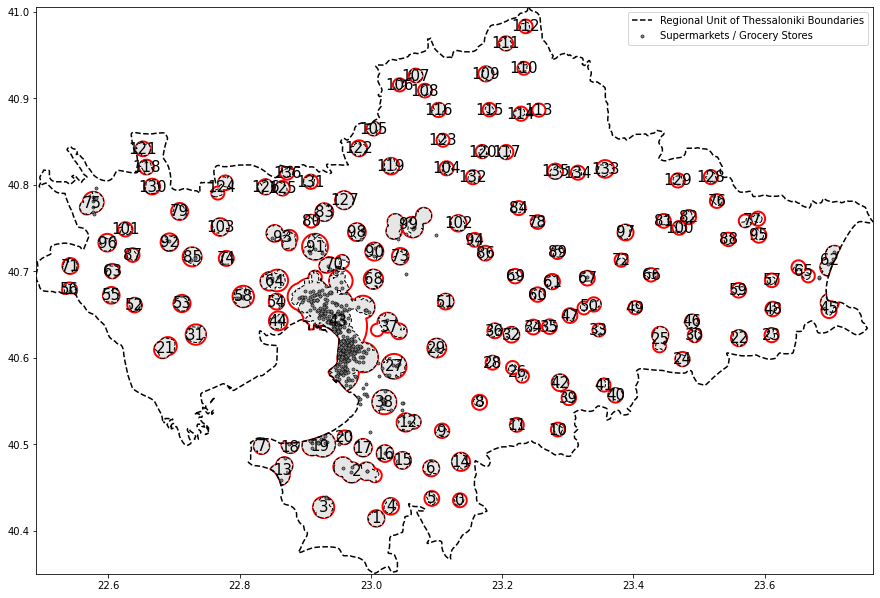

In [343]:
from shapely.geometry import Polygon
pd.options.display.max_rows = 160

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Create a geometric union of the town buffers
towns_union = gpd.GeoDataFrame(geometry=[Polygon(geom.exterior) for geom in towns.unary_union.geoms],
                               crs="EPSG:2100")

# Join town attributes to each town_union polygon and sum populations // Not utilized
towns_union = gpd.sjoin(towns_union, towns, how='inner', op='intersects')
towns_union['town_cluster'] = towns_union.index
towns_union = towns_union.dissolve(by='town_cluster', aggfunc={'Μόνιμος Πληθυσμός':'sum'}).reset_index()

# Filter out polygon errors
towns_union = towns_union[towns_union.area > 15000].reset_index(drop=True)
towns_union['town_cluster'] = towns_union.index
print("1) Towns Union: ", towns_union.shape)

# Isolate the residential streets and create a buffer for the required max distance
residential = road_network[road_network['class'] == 'residential'].to_crs(2100)
residential = residential.buffer(300, join_style=2)
print("2) Buffered Residential Streets: ", residential.shape)

# Clip the residential buffer areas to the extent of the town shapes
elligible_area = gpd.clip(residential, towns_union).unary_union

# Reformat the result as a GeoDataFrame with closed gaps
elligible_area = gpd.GeoDataFrame(geometry=[Polygon(geom.exterior) for geom in elligible_area.geoms], crs='EPSG:2100')
print("3) Residential buffers clipped to towns union: ", elligible_area.shape)

# _____________________________________________________________________________________________________

# Create an inner spatial join of the created elligible area with each town and extract town population
elligible_area = gpd.sjoin(elligible_area, towns_union, how='inner', op='intersects').drop('index_right', axis=1)
elligible_area['area_sq_m'] = elligible_area.area.round(2)
elligible_area.rename(columns={'Μόνιμος Πληθυσμός':'cluster_population'}, inplace=True)


# Estimate the portion of cluster population for each residential street polygon, based on area
elligible_area['area_sum'] = \
elligible_area[['area_sq_m', 'town_cluster']].groupby('town_cluster').transform('sum')
elligible_area['population_ratio'] = (elligible_area['cluster_population'] * \
(elligible_area['area_sq_m']/elligible_area['area_sum'])).astype(int)
elligible_area.reset_index(drop=True, inplace=True)
print("4) Residential buffers sjoined to towns: ", elligible_area.shape)

# Add the respective town clusters and residential area polygon info to each supermarket based on intersection
supermarkets = gpd.sjoin(supermarkets, elligible_area.to_crs(4326), how='left', op='intersects')
supermarkets.rename(columns={'index_right':'residential_polygon'}, inplace=True)
supermarkets = supermarkets.to_crs(2100)


def nearest_poly(x, other):
    
    distances = other.distance(x)
    
    return distances.argmin()
    

# Attach non-intersecting supermarkets to the nearest residential polygon and rerun join operation
supermarkets.loc[supermarkets.residential_polygon.isnull(), 'residential_polygon'] =\
supermarkets.loc[supermarkets.residential_polygon.isnull(), 'geometry'].transform(nearest_poly, other=elligible_area)
supermarkets = supermarkets.loc[:, 'id':'residential_polygon'].join(pd.DataFrame(elligible_area.drop(columns='geometry')),
                                                                    how='left',
                                                                    on='residential_polygon')

# Number of stores by town cluster and residential polygon
supermarkets['cluster_store_count'] = supermarkets[['id', 'town_cluster']].groupby('town_cluster').transform('count')
supermarkets['polygon_store_count'] = supermarkets[['id', 'residential_polygon']]\
.groupby('residential_polygon').transform('count')

# towns_union = towns_union.join(pd.DataFrame(supermarkets.drop(columns='geometry')).set_index('town_cluster'), how='left')
# print(towns_union)

elligible_area.sort_index(inplace=True)
elligible_area['cluster_store_count'] = supermarkets.sort_values('residential_polygon')\
                                        .groupby('residential_polygon').first()['cluster_store_count']
elligible_area['polygon_store_count'] = supermarkets.sort_values('residential_polygon')\
                                        .groupby('residential_polygon').first()['polygon_store_count']

def fillna(column): return column.fillna(method='ffill')
elligible_area['cluster_store_count'] = elligible_area[['town_cluster',
                                                        'cluster_store_count']].groupby('town_cluster').transform(fillna)
elligible_area.fillna(0, inplace=True)

#______________________________________________________________________________________________________


# Plot

nomos.boundary.to_crs(4326).plot(ax=ax, ls='--', color='black', label='Regional Unit of Thessaloniki Boundaries')

towns_union.to_crs(4326).plot(ax=ax, lw=2, facecolor="none", edgecolor='red', zorder=0)

elligible_area.to_crs(4326).plot(ax=ax, facecolor=(.9,.9,.9),
                                 edgecolor=(.0,.0,.0), ls='--', legend=True, zorder=1)
supermarkets.to_crs(4326).plot(ax=ax, facecolor='grey', edgecolor='black', label='Supermarkets / Grocery Stores',
                               markersize=10, lw=.5, zorder=2)

# Annotate indices for polygon identification
for i, polygon in towns_union['geometry'].to_crs(4326).iteritems():
    
    fontsize = 15
    ax.annotate(str(i), (polygon.centroid.coords.xy[0][0], polygon.centroid.coords.xy[1][0]), fontsize=fontsize,
                ha='center', va='center', zorder=3, annotation_clip=False, color='k')


ax.legend()

pd.options.display.max_rows=160

elligible_area

<center><h1>__________________</h1></center><br>
<center>
    <h2>Part B: Current state assessment</h2><br>
</center>

* A numerical measure has to be defined in order to assess current state and look for improvements. Generally speaking, a new store location should be refering to as many customers as possible, while the competition has to be kept low and potentially weighted by the distance to other stores.

* Additionally, since there is no information available regarding the distribution of population within each town, it will be assumed that the present supermarket stores are built around the highest demand, hence, the center of their mass will reflect the point with the highest population density for each town. Concluding, a location closer to the center of mass should provide a larger clientele.


### Defining an indicator for the assessment of existing store locations:

The candidate indicator to be defined should reveal the "suitability" of a position, meaning it should be high at high population numbers and low competition, while being low at low population numbers and high competition. A high indicator value should, therefore, indicate a better location.

Assuming that if all stores of an area were located at the center with negligible distance between them, this indicator would equal the population divided by the number of stores, the "share of the pie". If the stores are distant to eachother, we would like to devise a way to weigh this result by distance.

A potential candidate could be: <br><br>
`suitability = (population / number of stores) * (average distance to competition / distance to center mass)` <br><br>
the indicator above, satisfies the requirement for high values at high population numbers and low competition, penalizes locations relatively close to competition and further from the center of mass, while favoring locations further from competition and closer to the center of mass.

In order to normalize the distance index `i = average distace / center mass distance` to a [0, 1] interval, it will be passed to the sigmoid function `f(x) = 1 / (1 + e**-x)`.

The logistic function:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1280px-Logistic-curve.svg.png" alt="sigmoid" width="500px" heigh="400px">

### B.1. Calculate the required parameters and the suitability indicator:

In [427]:
def get_avg_distance(x, gdf):
        
    distances = gdf.distance(x)
    distances = distances[distances > 0]
    
    return distances.mean() if distances.shape[0] > 1 else 1


def get_center_mass_distance(x, gdf, assess_current=False, **kwargs):
    
    if gdf.shape[0] > 1:
        
        X, Y = LineString(gdf.geometry.values).xy
        centroid = Point(np.mean(X), np.mean(Y))
        
    else:
        
        if assess_current: return 1
        
        ''' 
        Incase of no competition present during grid search,
        use the centroid of corresponding towns_union cluster
        '''   

        centroid = towns_union.iloc[kwargs['cluster']].geometry.centroid
    
    return x.distance(centroid)


def compute_indicator(gdf, **kwargs):
    
    k = 1
    
    if 'k' in kwargs.keys():
    
        k = kwargs['k']
    
    distance_index = gdf['average_distance'] / gdf['center_mass_distance']
    a = gdf['cluster_population'] / gdf['cluster_store_count']
    b = 1 / (1 + np.exp(-k*(distance_index)))
    
    result = a * b
    
    return result


for cluster in supermarkets['town_cluster'].unique():
    
    supermarkets.loc[supermarkets.town_cluster == cluster, 'average_distance'] = \
    supermarkets.loc[supermarkets.town_cluster == cluster,
                     'geometry'].transform(get_avg_distance,
                                           gdf=supermarkets.loc[supermarkets.town_cluster == cluster])
    
    supermarkets.loc[supermarkets.town_cluster == cluster, 'center_mass_distance'] = \
    supermarkets.loc[supermarkets.town_cluster == cluster,
                    'geometry'].transform(get_center_mass_distance,
                                          gdf=supermarkets.loc[supermarkets.town_cluster == cluster],
                                          assess_current=True)

supermarkets['suitability_indicator'] = compute_indicator(supermarkets, k=1)
supermarkets

,id,name,lat,lng,geometry,residential_polygon,town_cluster,cluster_population,area_sq_m,area_sum,population_ratio,cluster_store_count,polygon_store_count,average_distance,center_mass_distance,suitability_indicator
0,4ba4e6caf964a520dfc038e3,LIDL,40.546076,22.982896,POINT (413724.988 4488579.900),21.0,38,16004,6897362.52,6897362.52,16004,16,16,2873.605935,2469.804987,762.157700
1,4c6443ec11c4a593dde3e811,Μασούτης,40.598802,22.958808,POINT (411754.413 4494456.583),26.0,43,789294,71556317.52,72154617.98,782749,347,346,3896.168036,3066.863512,1776.053864
2,4c7c0e3cbd346dcbb50bfdef,Μασούτης,40.603475,22.956994,POINT (411607.058 4494977.139),26.0,43,789294,71556317.52,72154617.98,782749,347,346,3628.539117,2528.553302,1837.174315
3,4c913f0dae45224b472be697,Μασούτης,40.590133,22.961055,POINT (411933.149 4493492.025),26.0,43,789294,71556317.52,72154617.98,782749,347,346,4546.521286,4047.840859,1716.387315
4,4cb03f72562d224b73b61488,Μασούτης,40.556176,22.994215,POINT (414696.283 4489690.023),21.0,38,16004,6897362.52,6897362.52,16004,16,16,2206.684074,1573.524910,802.762352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,5e50ccb7093267000791bbb4,LIDL,40.677024,22.899537,POINT (406847.978 4503200.711),26.0,43,789294,71556317.52,72154617.98,782749,347,346,7406.529683,7188.953386,1676.322475
450,5404737f498e0d41120bd703,Μασούτης,40.688591,22.848905,POINT (402585.658 4504539.517),76.0,64,14156,5457875.05,5483699.42,14089,3,3,707.963458,417.158980,3988.011924
451,4ded0b0622719aa55246b062,Γαλαξίας,40.748230,22.987492,POINT (414372.487 4511015.757),108.0,98,3302,3394909.52,3394909.52,3302,4,4,436.243545,321.242453,656.629592
452,4dee593545dd3aa41d7abd34,Αρβανιτίδης,40.600583,22.956244,POINT (411539.816 4494656.836),26.0,43,789294,71556317.52,72154617.98,782749,347,346,3787.619770,2835.875648,1800.970656


### B.2. Visualize parameter relationship:

Text(0.5, 1.0, 'The relationship between Average Distance and Distance from Center of Mass')

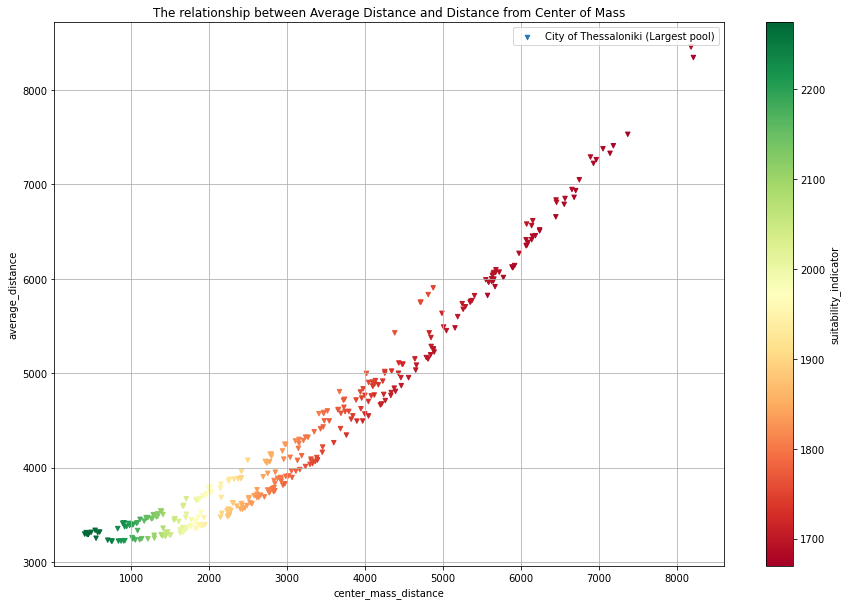

In [428]:
fig, ax1 = plt.subplots(figsize=(15, 10))

plot = supermarkets.loc[supermarkets.town_cluster==43][['average_distance', 'center_mass_distance',
                                                'suitability_indicator']].plot(x='center_mass_distance',
                                                                               y='average_distance',
                                                                               kind='scatter',
                                                                               grid=True,
                                                                               ax=ax1,
                                                                               label='City of Thessaloniki'\
                                                                                  ' (Largest pool)',
                                                                               marker='v',
                                                                               c='suitability_indicator',
                                                                               cmap='RdYlGn')

plot.set_title("The relationship between Average Distance and Distance from Center of Mass")


Observing the above relationships, the distance index appears to be functioning as expected. The approach, however, might not be as great for a large city like Thessaloniki, since it most likely has multiple centers which are not being considered. Additionally, the distances can get too long for the stores to affect the competition in the defined way. A different indicator that defines a better relationship in that case, would be more adequate.

### B.3. Visualizing indicator results:

Mean value:  1790.23


,Mean Suitability Indicator Value per Brand
name,
Bazaar,1952.709575
Μασούτης,1902.155807
AB Βασιλόπουλος,1854.198195
Σκλαβενίτης,1830.626420
Άριστα,1828.536546
Discount Markt,1783.628285
Αρβανιτίδης,1752.108168
Ελληνικά Market,1747.352974
Αφροδίτη,1745.061086


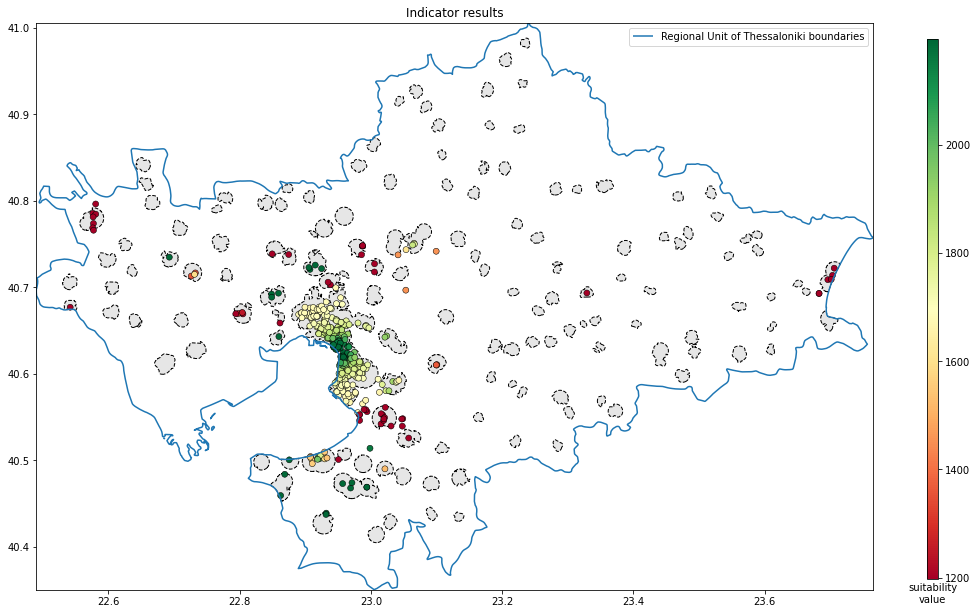

In [429]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title('Indicator results')

cax = fig.add_axes([.95, .25, .01, .5])
cax.set_xlabel('suitability\nvalue')

nomos.to_crs(4326).boundary.plot(ax=ax, label='Regional Unit of Thessaloniki boundaries')
elligible_area.to_crs(4326).plot(ax=ax, facecolor=(.9,.9,.9),
                                 edgecolor=(.0,.0,.0), ls='--', zorder=0)
supermarkets.to_crs(4326).plot(ax=ax, column='suitability_indicator',
                                      edgecolor=(0,0,0), lw=.5,
                                      cmap='RdYlGn', cax=cax, legend=True,
                                      vmin=supermarkets.suitability_indicator.quantile(.1),
                                      vmax=supermarkets.suitability_indicator.quantile(.9))
ax.legend()


brand_ranking=\
supermarkets.groupby('name').aggregate({'suitability_indicator':'mean'})\
.sort_values('suitability_indicator', ascending=False)\
.rename(columns={'suitability_indicator':'Mean Suitability Indicator Value per Brand'})

print("Mean value: ", supermarkets['suitability_indicator'].mean().round(2))
brand_ranking

The indicator would ofcourse be needing elaborate testing and further tuning, but for the purpose of this project it will be considered sufficient. The average grade for the AB Vasilopoulos brand is **1854**, above the average of 1790. Hence, we will have to look for locations that improve this value:

`suitability indicator > 1854`.

<center><h1>__________________</h1></center><br>
<center><h2>Part C: Identifying suitable investment locations based on the defined indicator</h2></center>

### C.1. Grid Search:
A grid of points will be created for the purpose of calculating the previously defined suitability indicator for each point. Sequentially, the points will be filtered down to those with values higher than the brand's average grade. Those points should indicate candidate locations that will improve the brand's position in the region, based on the defined indicator.

Grids will be applied to each elligible area polygon separately in __300-meter intervals__. Since a point-grid would only make sense for polygons with competition present, for polygons without competition it should only return the polygon centroid.

,residential_polygon,geometry,town_cluster,cluster_population,area_sq_m,area_sum,population_ratio,cluster_store_count,polygon_store_count
10,0,POINT (415252.972 4473161.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0
11,0,POINT (415552.972 4473161.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0
12,0,POINT (415852.972 4473161.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0
13,0,POINT (416152.972 4473161.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0
17,0,POINT (414952.972 4473461.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0
...,...,...,...,...,...,...,...,...,...
8574,158,POINT (435200.641 4537075.132),112,161,1128331.90,1128331.90,161,1.0,0.0
8575,158,POINT (435500.641 4537075.132),112,161,1128331.90,1128331.90,161,1.0,0.0
8576,158,POINT (435800.641 4537075.132),112,161,1128331.90,1128331.90,161,1.0,0.0
8579,158,POINT (435500.641 4537375.132),112,161,1128331.90,1128331.90,161,1.0,0.0


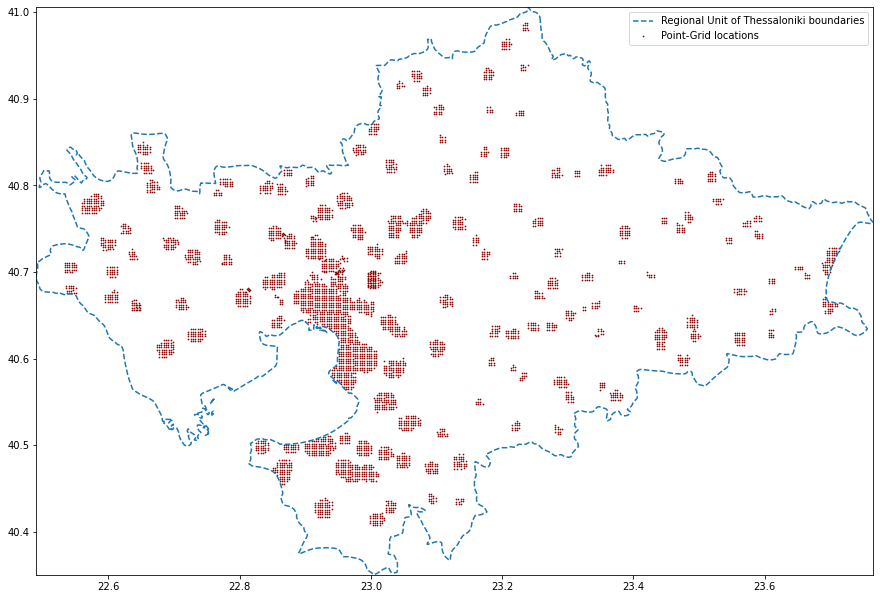

In [347]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

def create_grid(poly_gdf, interval):
    
    points = []
    polygons = []
    
    for i, polygon in poly_gdf.geometry.iteritems():
        
        
        xmin, ymin, xmax, ymax = polygon.bounds

        X = np.arange(xmin, xmax, interval)
        Y = np.arange(ymin, ymax, interval)

        X, Y = np.meshgrid(X, Y)

        coords = zip(X.reshape(-1), Y.reshape(-1))

        for x, y in coords:

            points.append(Point(x, y))
            polygons.append(i)
   
    
    gdf = gpd.GeoDataFrame({'residential_polygon':polygons}, geometry=points, crs="EPSG:2100")
    
    return gpd.clip(gdf, elligible_area)


candidate_locations = create_grid(elligible_area, 300)
candidate_locations = gpd.sjoin(candidate_locations, elligible_area, how='left', op='intersects').drop(columns='index_right')

# Increase Supermarket count by 1, to account for the candidate location
candidate_locations['cluster_store_count'] += 1

nomos.to_crs(4326).boundary.plot(ax=ax, label='Regional Unit of Thessaloniki boundaries', ls='--')
candidate_locations.to_crs(4326).plot(ax=ax, markersize=.5, label='Point-Grid locations', color='darkred')

ax.legend()

candidate_locations

### C.2. Calculating the suitability indicator for the candidate locations:

In [415]:
for cluster in candidate_locations.town_cluster.unique():
    
    candidate_locations.loc[candidate_locations.town_cluster == cluster, 'average_distance'] = \
    candidate_locations.loc[candidate_locations.town_cluster == cluster, 'geometry'].transform\
    (
        get_avg_distance, gdf=supermarkets.loc[supermarkets.town_cluster == cluster]
    )
    
    candidate_locations.loc[candidate_locations.town_cluster == cluster, 'center_mass_distance'] = \
    candidate_locations.loc[candidate_locations.town_cluster == cluster, 'geometry'].transform\
    (
        get_center_mass_distance, gdf=supermarkets.loc[supermarkets.town_cluster == cluster], cluster=cluster
    )


candidate_locations['suitability_indicator'] = compute_indicator(candidate_locations, k=1)
candidate_locations

,residential_polygon,geometry,town_cluster,cluster_population,area_sq_m,area_sum,population_ratio,cluster_store_count,polygon_store_count,average_distance,center_mass_distance,suitability_indicator
10,0,POINT (415252.972 4473161.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0,1.0,883.894542,916.017878
11,0,POINT (415552.972 4473161.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0,1.0,772.803268,916.092324
12,0,POINT (415852.972 4473161.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0,1.0,770.181941,916.094340
13,0,POINT (416152.972 4473161.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0,1.0,877.003737,916.021948
17,0,POINT (414952.972 4473461.404),1,1831,3327463.36,3327463.36,1831,1.0,0.0,1.0,883.894542,916.017878
...,...,...,...,...,...,...,...,...,...,...,...,...
8574,158,POINT (435200.641 4537075.132),112,161,1128331.90,1128331.90,161,1.0,0.0,1.0,423.689323,80.594999
8575,158,POINT (435500.641 4537075.132),112,161,1128331.90,1128331.90,161,1.0,0.0,1.0,200.367335,80.700881
8576,158,POINT (435800.641 4537075.132),112,161,1128331.90,1128331.90,161,1.0,0.0,1.0,284.220857,80.641615
8579,158,POINT (435500.641 4537375.132),112,161,1128331.90,1128331.90,161,1.0,0.0,1.0,489.657551,80.582200


### C.3. Visualize the candidate location indicator results:

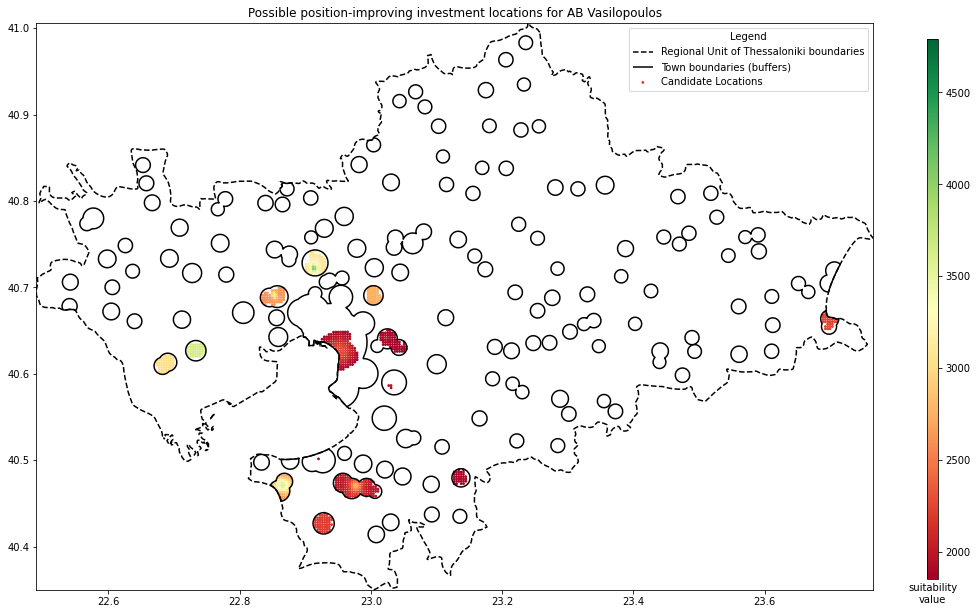

In [423]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

cax = fig.add_axes([.95, .25, .01, .5])
cax.set_xlabel('suitability\nvalue')

nomos.to_crs(4326).boundary.plot(ax=ax, ls='--', color='black', label='Regional Unit of Thessaloniki boundaries')
towns_union.to_crs(4326).boundary.plot(ax=ax, color='k', label='Town boundaries (buffers)')

p = candidate_locations[candidate_locations.suitability_indicator > 1854]\
    .to_crs(4326).plot(ax=ax, column='suitability_indicator', markersize=3,
                       vmin=brand_ranking.loc['AB Βασιλόπουλος'],
                       vmax=supermarkets.loc[supermarkets.name == 'AB Βασιλόπουλος', 'suitability_indicator'].max(),
                       cmap='RdYlGn', cax=cax, legend=True, label='Candidate Locations')

ax.set_title('Possible position-improving investment locations for AB Vasilopoulos')
ax.legend(title='Legend')



The map above presents the ranked position-improving investment locations for the AB Vasilopoulos brand. These locations can now be used for the conduction of a targeted investment study and identify suitable properties for investment using elaborate economic criteria, cost estimation, sustainability etc.

<center><h1>__________________</h1></center><br>
<center><h2>Part D: Conclusions</h2></center>

Based on the results, the economic center of the region seems to have increased competition and a new investment could be considered average and of higher risk. Instead, the results indicate that greater and safer expansion opportunities could be possible on the western area of the region, based on demand and competition.